# Projekat 1 - 40 bodova

U VCF fajlu su dati rezultati studije u kojoj su prikupljani podaci o mutacijama u određenoj populaciji (tabela sa imenom eksperimenta koji je dodeljen svakom studentu je data u fajlu Lista zadataka 2020). Osobe zahvaćene nekom bolešću su označene kao *case_x*, a zdrave osobe sa *control_x*.

Kao rezultat projekta se potrebno je predati:  
1. Kod kojim su generisani rezultati (ipynb ili python skripta)
2. Kraći izveštaj sa tekstualnim odgovorima na pitanja i grafikonima

Projekat je moguće raditi pojedinačno ili u paru. **Ukoliko se projekat radi u paru, svaki student predaje i brani projekat posebno, uz napomenu da je projekat urađen u paru; pri tome svaki student treba da obradi podatke iz eksperimenta koji mu dodeljen, a rad u paru se odnosi na programski kod i šablon za tekstualni izveštaj.**

Pitanja:

1. [3 boda] Koliko je subjekata ukupno učestvovalo u studiji? Koliko njih su oboleli, a koliko zdravi?
 
2. [5 bodova] Koliko je ukupno mutacija posmatrano u populaciji. Dati tabelu sa brojem mutacija po hromozomu.
   
3. [8 bodova] Nacrtati histograme:  
  3a. [2 boda] Frekvencije ređih alela (minor allele frequency, MAF) za svaku mutaciju u studiji  
  3b. [2 boda] Procenat homozigotnih referentnih uzoraka za svaku mutacija u studiji  
  3c. [2 boda] Procenat homozigotnih alternativnih uzoraka za svaku mutacija u studiji  
  3d. [2 boda] Procenat heterozigotnih uzoraka za svaku mutacija u studiji     
      
4. [17 bodova] Identifikovati mutacije koje su statistički značajno asocirane sa datom bolešću (p manje od 0.05, upotrebom hi kvadrat testa).  
  4a. [5 bodova] Primeniti hi kvadrat test na sve mutacije u studiji
  4b. [3 bodova] Da li je potrebno izvršiti korekciju za višestruko testiranje? Ukoliko jeste, objasniti kako, i primeniti je.  
  4c. [4 bodova] Nacrtati Menhetn grafikon. Voditi računa da dužina duž X ose alocirana svakom hromozomu bude proporcionalna dužini hromozoma.  
  4d. [5 bodova] Za svaku mutaciju koja je statistički značajno asocirana sa datom bolešću odrediti da li odstupa od Hardi-Vajnberg ekvilibrijuma (upotrebom hi kvadrat testa).

5. [7 bodova] Na osnovu mutacije koja pokazuje najjaču asocijaciju sa bolešću odrediti region na referentnom genomu gde se verovatno nalazi gen koji uzrokuje bolest.
  5a. [4 boda] Identifikovati jedan ili više mogućih gena upotrebom [UCSC Genome browsera](https://genome.ucsc.edu/cgi-bin/hgGateway?redirect=manual&source=genome.ucsc.edu). Studija je rađena prema GRCH37 referentnom genomu.
  5b. [3 boda] Izvući podatke o bolestima vezanim za identifikovane gene sa [OMIM sajta](https://omim.org) (nije potrebno prevoditi na srpski jezik).

Mount Google Drive to access VCF



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Define file and directory aliases

In [ ]:
root_dir = '/content/'
home_dir = root_dir + 'drive/MyDrive/Colab Notebooks/UUB/'
data_dir = home_dir + 'data/'

%cd {home_dir}

Unzip VCF archive if needed

In [ ]:
!gunzip '{data_dir}experiment_11.vcf.gz'

Install Pysam library to parse VCF

In [ ]:
!pip install pysam

Import required libraries

In [5]:
import math
import pysam
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from itertools import groupby
from collections import Counter

warnings.simplefilter("error", RuntimeWarning)

Open VCF

In [8]:
vcf = pysam.VariantFile(data_dir + 'experiment_11.vcf')

Count samples

In [9]:
samples = vcf.header.samples
cases = {s for s in vcf.header.samples if s.startswith('case')}
controls = {s for s in vcf.header.samples if s.startswith('control')}

len_samples, len_cases, len_controls = len(samples), len(cases), len(controls)

In [10]:
print('Total={} Case={} Control={}'.format(len_samples, len_cases, len_controls))

Total=200 Case=100 Control=100


Fetch all mutations

In [11]:
variants = list(vcf.fetch())

Count mutations and show total count per chromosome table

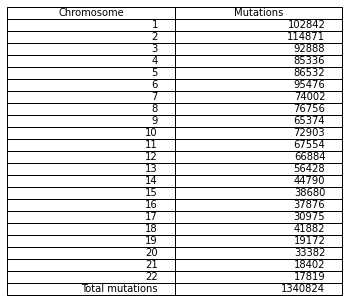

In [12]:
muts_per_chrom = Counter([v.chrom for v in variants])
len_variants = sum(muts_per_chrom.values())

freq_data = [[k, v] for k, v in muts_per_chrom.items()]
freq_data.append(['Total mutations', len_variants])

freq_labels = ['Chromosome', 'Mutations']
freq_table = plt.table(cellText=freq_data, colLabels=freq_labels, loc='center')

plt.axis('off')
plt.show()

Extract Minor Allele Frequency (MFA) and sampled genotypes per mutation

In [13]:
def get_genotypes():
    maf_list, ref_list, alt_list, het_list = [], [], [], []

    for v in variants:
        counts = Counter([sum(v.samples[s]['GT']) for s in samples])
        refs, alts, hets = counts[0], counts[2], counts[1]

        maf_list.append((2 * min(refs, alts) + hets) / (2 * len_samples))
        ref_list.append(refs / len_samples)
        alt_list.append(alts / len_samples)
        het_list.append(hets / len_samples)

    return maf_list, ref_list, alt_list, het_list

In [14]:
%%time
maf, ref, alt, het = get_genotypes()

CPU times: user 4min 44s, sys: 345 ms, total: 4min 44s
Wall time: 4min 44s


Show histograms

In [15]:
def show_hist(data, label, index):
    plt.subplot(1, 4, index)
    plt.hist(data, bins=25, label=label)
    plt.legend()

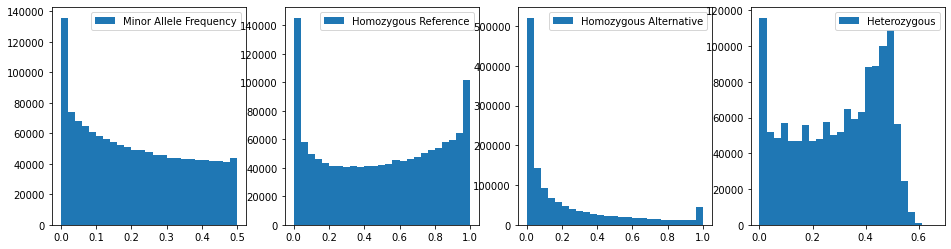

In [16]:
plt.figure(figsize=(16, 4))
show_hist(maf, 'Minor Allele Frequency', 1)
show_hist(ref, 'Homozygous Reference', 2)
show_hist(alt, 'Homozygous Alternative', 3)
show_hist(het, 'Heterozygous', 4)
plt.show()

Run Chi-Square test for each mutation

In [17]:
def run_chi2(v):
    case_counts = Counter([sum(v.samples[s]['GT']) for s in cases])
    case_refs = 2 * case_counts[0] + case_counts[1]
    case_alts = 2 * case_counts[2] + case_counts[1]

    control_counts = Counter([sum(v.samples[s]['GT']) for s in controls])
    control_refs = 2 * control_counts[0] + control_counts[1]
    control_alts = 2 * control_counts[2] + control_counts[1]

    total = case_refs + case_alts + control_refs + control_alts

    try:
        observed = [case_refs, case_alts, control_refs, control_alts]
        expected = [(case_refs + case_alts) * (case_refs + control_refs) / total,
                    (case_refs + case_alts) * (case_alts + control_alts) / total,
                    (control_refs + control_alts) * (case_refs + control_refs) / total,
                    (control_refs + control_alts) * (case_alts + control_alts) / total]
        return chisquare(observed, expected, ddof=2).pvalue
    except Warning:
        return None

In [18]:
%%time
chi2_raw = [(v.chrom, v.pos, run_chi2(v)) for v in variants]
chi2 = [x for x in chi2_raw if x[2] is not None]
results = {k: list(v) for k, v in groupby(chi2, key=lambda x: x[0])}

CPU times: user 7min 12s, sys: 962 ms, total: 7min 13s
Wall time: 7min 13s


Calculate chromosome lengths

In [19]:
def chrom_lengths():
    chrom_groups = groupby(variants, key=lambda v: v.chrom)
    return [max([v.pos for v in g]) for _, g in chrom_groups]

Show Manhattan plot

In [20]:
def show_manhattan(bonferroni = False):
    lengths = chrom_lengths()
    widths = [math.ceil(100 * x / sum(lengths)) for x in lengths]

    plt.figure(figsize=(16, 4))

    for i, chrom in enumerate(results):
        pos = [x[1] for x in results[chrom]]
        p = [-np.log10(x[2]) for x in results[chrom]]

        plt.subplot2grid((1, sum(widths)), (0, sum(widths[:i])), colspan=widths[i])
        plt.scatter(pos, p)
        plt.ylim(0, 15)
        plt.axhline(-np.log10(0.01 / len_variants if bonferroni else 0.01), c='r')

    plt.show()

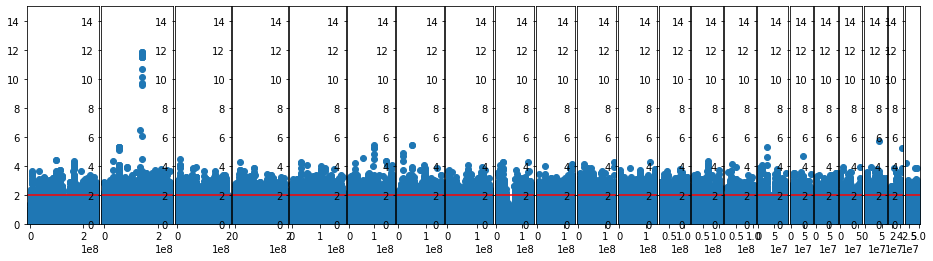

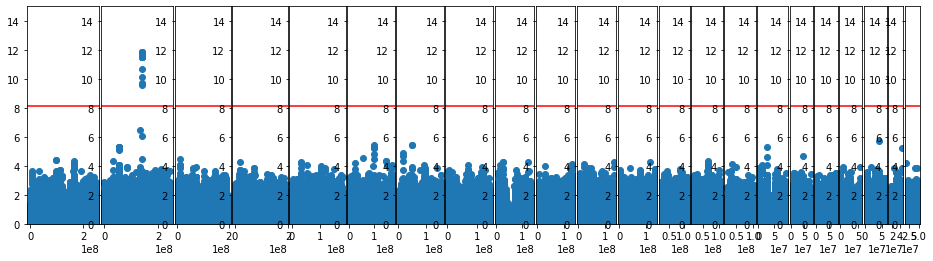

In [21]:
show_manhattan()
show_manhattan(True)

Extract regions with most significant mutations

In [22]:
def get_regions():
    regions = []
    
    for i, chrom in enumerate(results):
        pos = [x[1] for x in results[chrom]]
        p = [-np.log10(x[2]) for x in results[chrom]]

        signif = [x for x in p if x > -math.log10(0.01 / len_variants)]

        pos_min, pos_max = float('inf'), float('-inf')
    
        for j, x in enumerate(p):
            if x in signif:
                pos_min, pos_max = min(pos_min, pos[j]), max(pos_max, pos[j])

        if pos_min != float('inf') and pos_max != float('-inf'):
            regions.append({'chr' : i + 1, 'min' : pos_min, 'max' : pos_max})

    return regions

Check if mutation is inside region

In [23]:
def isinside(v, r):
    return int(v.chrom) == r['chr'] and r['min'] <= v.pos < r['max']

In [24]:
signif = [v for r in get_regions() for v in variants if isinside(v, r)]

Check Hardy-Weinberg equilibrium for each significant mutation

In [25]:
def check_hwe(v):
    counts = Counter([sum(s['GT']) for s in v.samples.values() if None not in s['GT']])
    total = sum(counts.values())
    
    p = (2 * counts[0] + counts[1]) / (2 * total)
    q = (2 * counts[2] + counts[1]) / (2 * total)

    try:
        observed = [counts[0], counts[1], counts[2]]
        expected = [p * p * total, 2 * p * q * total, q * q * total]
        return chisquare(observed, expected, ddof=1).pvalue
    except Warning:
        return None

In [26]:
hwe_raw = [check_hwe(v) for v in signif]
hwe = [x > (0.01 / len_variants) for x in hwe_raw if x is not None]

Show HWE results for each significant mutation

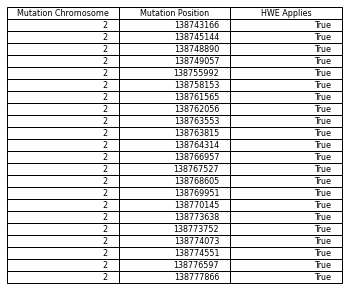

In [27]:
hwe_data = [[v.chrom, v.pos, h] for (v, h) in zip(signif, hwe)]
hwe_labels = ['Mutation Chromosome', 'Mutation Position', 'HWE Applies']
hwe_table = plt.table(cellText=hwe_data, colLabels=hwe_labels, loc='center')

plt.axis('off')
plt.show()

Show all significant regions

Extract relevant genes in this regions using [UCSC Genome browser](https://genome.ucsc.edu/cgi-bin/hgGateway?redirect=manual&source=genome.ucsc.edu)

In [28]:
for r in get_regions():
    print('chr{}:{}-{}'.format(r['chr'], r['min'], r['max']))

chr2:138743166-138778828
